In [1]:
import glob

import numpy as np

import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import skimage
from skimage import exposure, io



import torch
from torchvision.utils import save_image

#torch.backends.cudnn.benchmark = True
torch.backends.cudnn.benchmark = False

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp


dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(dev)
#print(torch.__version__)



In [2]:
# image path
img_path_train="../train/"
img_path_valid="../val/"

# figure size 
figsize = 512

# encoder
encoder='resnet18'
#encoder='resnet34'
#encoder='resnet50'
#encoder='resnet101'
#encoder='resnet151'

# weights
encoder_weights='imagenet'
#encoder_weights='ssl'
#encoder_weights='swsl'



In [3]:
def preprocess(img,mn=0,mx=100):
    mx1 = np.max(img).astype(np.float32)
    mn1 = np.min(img).astype(np.float32)
    img = (img.astype(np.float32)-mn1)/(mx1-mn1)
#    img = exposure.equalize_adapthist(img.astype(np.uint16))
#    img = exposure.equalize_hist(img)

    i, j = np.percentile(img, (mn,mx))
    img = exposure.rescale_intensity(img, in_range=(i,j)).astype(np.float32)
    return img

In [4]:
model = smp.Unet(encoder, in_channels=1)

In [5]:
imglist = sorted(glob.glob(img_path_valid+"*.tif"))

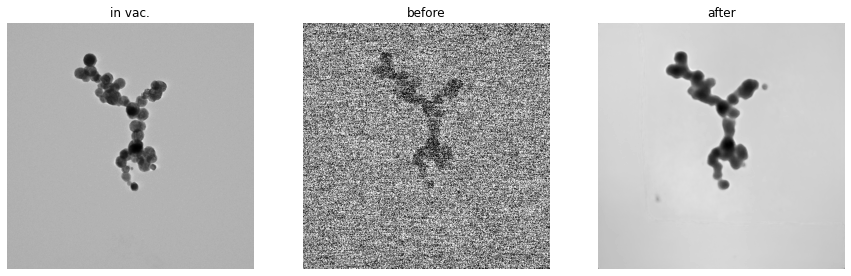

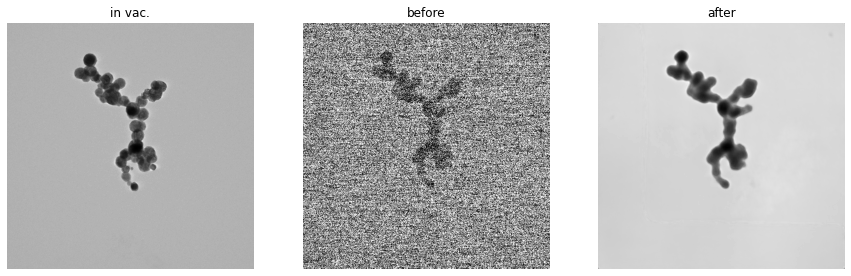

In [6]:
model.eval()

model.load_state_dict(torch.load("../params/params.pth", map_location=torch.device(dev)))


j=0
for i in imglist:
    if j%4 == 0:
        img1 = io.imread(i).astype(np.float32)
        img1 = cv2.resize(img1, (figsize,figsize))
        i2 = i
        j=j+1
        continue
    elif j%4 == 1:
        img2 = io.imread(i).astype(np.float32)
        img2 = cv2.resize(img2, (figsize,figsize))
        j=j+1
    elif j%4 == 2:
        img2 = io.imread(i).astype(np.float32)
        img2 = cv2.resize(img2, (figsize,figsize))
        j=j+2
    else:
        print('error: j={}'.format(j))
    
    img1_p = preprocess(img1)
    img2_p = preprocess(img2, mn=1, mx=80)
    img2_t = torch.from_numpy(img2_p).unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad():
        pred = model(img2_t)

    fig, ax = plt.subplots(1,3, figsize=(15,15))

    ax[0].imshow(img1_p, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title("in vac.")
    ax[1].imshow(img2_p, cmap='gray')
    ax[1].set_title("before")
    ax[1].set_axis_off()
    ax[2].imshow(pred[0,0], cmap='gray')
    ax[2].set_title("after")
    ax[2].set_axis_off()

    plt.show
    
save_image(pred,"test.jpg")